In [242]:
import dbcollection as dbc
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
mpii_pose = dbc.load('mpii_pose')

==> Dataset 'mpii_pose' not found in cache.
Proceeding to download the data files...
==> Download mpii_pose data to disk...
Creating save directory in disk: /home/furiousteabag/dbcollection/downloads/mpii_pose
Creating save directory in disk: /home/furiousteabag/dbcollection/mpii_pose


100% (11805608 of 11805608) |############| Elapsed Time: 0:04:29 Time:  0:04:29


patool: Extracting /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz ...
patool: running /bin/tar --extract -z --file /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz --directory /home/furiousteabag/dbcollection/downloads/mpii_pose
patool: ... /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1.tar.gz extracted to `/home/furiousteabag/dbcollection/downloads/mpii_pose'.


100% (12051 of 12051) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


patool: Extracting /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1_u12_2.zip ...
patool: ... /home/furiousteabag/dbcollection/downloads/mpii_pose/mpii_human_pose_v1_u12_2.zip extracted to `/home/furiousteabag/dbcollection/downloads/mpii_pose'.
==> Dataset download complete.
==> Updating the cache manager
==> Processed metadata not found for dataset 'mpii_pose', task 'keypoints'.
Proceeding to process the metadata for this task...
==> Setup directories to store the data files.
==> Process 'mpii_pose' metadata to disk...

Processing 'keypoints' task:

==> Storing metadata to file: /home/furiousteabag/dbcollection/mpii_pose/keypoint.h5

==> Loading data annotations from disk... Done.

Saving set metadata: train

==> Setting up the data fields:
> Processing 'image_filenames' metadata... Done.
> Processing 'scale' metadata... Done.
> Processing 'objpos' metadata... Done.
> Processing 'video_ids' metadata... Done.
> Processing 'video_names' metadata... Done.
> Process

In [3]:
mpii_pose

DataLoader: mpii_pose ('keypoints' task)

In [2]:
data = pd.read_csv('../data/kaggle_mpii/mpii_human_pose.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17372 entries, 0 to 17371
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            17372 non-null  int64  
 1   NAME          17372 non-null  object 
 2   r ankle_X     17372 non-null  int64  
 3   r ankle_Y     17372 non-null  int64  
 4   r knee_X      17372 non-null  int64  
 5   r knee_Y      17372 non-null  int64  
 6   r hip_X       17372 non-null  int64  
 7   r hip_Y       17372 non-null  int64  
 8   l hip_X       17372 non-null  int64  
 9   l hip_Y       17372 non-null  int64  
 10  l knee_X      17372 non-null  int64  
 11  l knee_Y      17372 non-null  int64  
 12  l ankle_X     17372 non-null  int64  
 13  l ankle_Y     17372 non-null  int64  
 14  pelvis_X      17372 non-null  int64  
 15  pelvis_Y      17372 non-null  int64  
 16  thorax_X      17372 non-null  int64  
 17  thorax_Y      17372 non-null  int64  
 18  upper neck_X  17372 non-nu

In [500]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

/home/furiousteabag/Projects/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


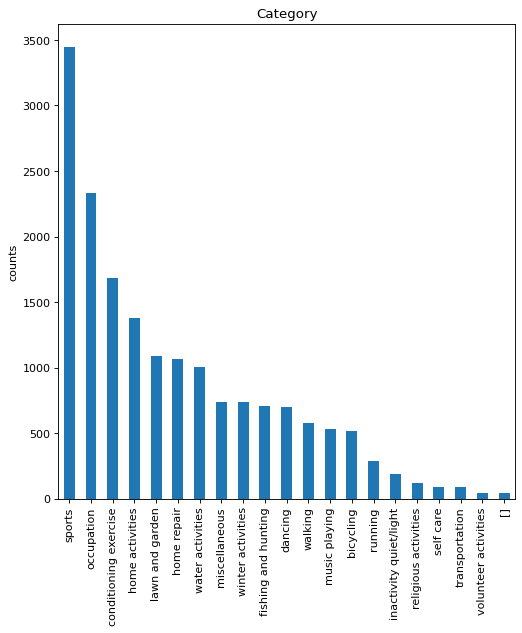

In [501]:
plotPerColumnDistribution(data, 10, 5)

In [279]:
len(data.loc[(data['Activity'].str.contains('sleeping'))])

12

In [258]:
cats = set(list(data['Category']))
print(cats)

{'winter activities', 'home activities', 'inactivity quiet/light', 'dancing', 'miscellaneous', 'water activities', 'occupation', 'fishing and hunting', 'transportation', 'running', '[]', 'music playing', 'walking', 'bicycling', 'sports', 'conditioning exercise', 'volunteer activities', 'home repair', 'lawn and garden', 'self care', 'religious activities'}


In [259]:
with open('../data/mpii_anns/mpii_trainval.json') as f:
    mpii_data = json.load(f)

In [260]:
len(mpii_data)

29116

In [319]:
my_mpii = []

In [320]:
good_cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting']

In [321]:
good_acts = ['standing', 'sitting', 'skiing', 'swimming', 'cooking', 
             'driving', 'rock climbing', 'horseback', 'skateboarding',
             'yoga', 'canoe', 'training', 'lying']

In [329]:
len(good_cats) + len(good_acts) + 1

19

In [322]:
for i in mpii_data:
    name = i['image']
    cat = data.loc[data['NAME'] == name]['Category'].values
    act = data.loc[data['NAME'] == name]['Activity'].values
    if len(cat) > 0:
        if (cat[0] in good_cats):
            i['category'] = cat[0]
            my_mpii.append(i)
        elif (cat[0] == 'sports' and bool(re.search('\wball', act[0]))):
            i['category'] = 'sport with ball'
            my_mpii.append(i)
        else:
            for good_act in good_acts:
                if good_act in act[0]:
                    i['category'] = good_act
                    my_mpii.append(i)

In [323]:
len(my_mpii)

14614

In [324]:
my_mpii

[{'joints_vis': [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'joints': [[-1.0, -1.0],
   [355.0, 408.0],
   [269.0, 354.0],
   [432.0, 333.0],
   [464.0, 425.0],
   [-1.0, -1.0],
   [351.0, 344.0],
   [310.0, 158.0],
   [308.4257, 139.7834],
   [297.5743, 14.2166],
   [335.0, 328.0],
   [212.0, 304.0],
   [230.0, 168.0],
   [389.0, 147.0],
   [492.0, 259.0],
   [413.0, 321.0]],
  'image': '021233911.jpg',
  'scale': 3.781047,
  'center': [304.0, 264.0],
  'category': 'sitting'},
 {'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'joints': [[357.0, 353.0],
   [369.0, 330.0],
   [366.0, 296.0],
   [443.0, 308.0],
   [470.0, 332.0],
   [435.0, 371.0],
   [405.0, 302.0],
   [404.0, 201.0],
   [405.772, 194.4489],
   [435.228, 85.5511],
   [331.0, 252.0],
   [354.0, 261.0],
   [357.0, 200.0],
   [451.0, 202.0],
   [484.0, 246.0],
   [468.0, 253.0]],
  'image': '021233911.jpg',
  'scale': 3.38434,
  'center': [361.0, 303.0],
  'category': 'sitting'},
 {'joints_vis': [

In [326]:
with open('../data/mpii.json', 'w') as f:
    json.dump(my_mpii, f)

In [335]:
cats = ['running', 'dancing', 'bicycling', 'walking', 'fishing and hunting', 'sport with ball',
                           'standing', 'sitting', 'skiing', 'swimming', 'cooking', 'driving', 'rock climbing', 
                           'horseback', 'skateboarding', 'yoga', 'canoe', 'training', 'lying']

In [331]:
import torch

In [360]:
target = torch.randint(0, 19, (19,))
one_hot = torch.nn.functional.one_hot(torch.arange(0, 19))

In [536]:
one_hot[4]

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [533]:
cats.index('dancing')

1

In [537]:
j = my_mpii[12110]

In [538]:
j = j['joints']

In [540]:
j = [[y/256 for y in x] for x in j]

In [654]:
j = [[2.8078, 2.9995],
        [2.1138, 2.9931],
        [2.1459, 1.9807],
        [2.0122, 1.5803],
        [2.6497, 2.7758],
        [2.6507, 2.3042],
        [2.2732, 0.5882],
        [1.9636, 1.4087],
        [1.2119, 2.1380],
        [1.1118, 1.7498],
        [1.2209, 0.7400],
        [1.0902, 1.4454],
        [1.4251, 0.9829],
        [1.3001, 1.7583],
        [1.2680, 1.0478],
        [1.0113, 1.2626]]

In [655]:
lines = [(0,1),(1,2),(2,6),(6,3),(3,4),(4,5),(6,7),(7,8),(8,9),(10,11),(11,12),(12,7),(7,13),(13,14),(14,15)]

In [656]:
pose_dict = {0: 'right_ankle',
        1: 'right_knee',
        2: 'right_hip',
        3: 'left_hip',
        4: 'left_knee',
        5: 'left_ankle',
        6: 'pelvis',
        7: 'thorax',
        8: 'upper_neck',
        9: 'head_top',
        10: 'right_wrist',
        11: 'right_elbow',
        12: 'right_shoulder',
        13: 'left_shoulder',
        14: 'left_elbow',
        15: 'left_wrist'}

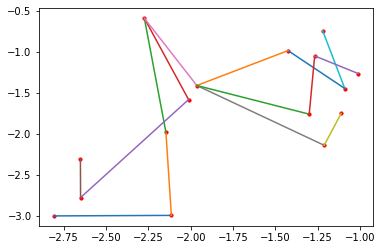

In [658]:
draw_keypoints(j)